In [5]:
#!pip install lightgbm

In [25]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [26]:
# working directory check
# %pwd

In [27]:
# data read
data = pd.read_csv('../data/okm_diak_adat.csv', low_memory = False)
data.head()

,Unnamed: 0,telephely_azonosito,X.x,sorszam_diak,oszt_letszam,tanarok_szama,osztid,tipus,mkod_th,teltip7_th,...,t55e,t56,X.y,tanarok_szama_telephelyen,megye_kodja,telepulestipus,fenntarto_tipuscsoport,diak_osszletszama_telephelyen,egy_diakra_mukodesi_kiadas_eFt_2019,osszes_mukodesi_kiadas_eFt
0,1,2720701,53413,53427,20,25.5,1,1,2,3,...,0.0,2.0,1,25.5,2,3,3,240,795.939575,184657.984375
1,2,2720701,51101,51115,13,25.5,2,1,2,3,...,0.0,3.0,1,25.5,2,3,3,240,795.939575,184657.984375
2,3,2720701,4527,4531,13,25.5,2,1,2,3,...,0.0,5.0,1,25.5,2,3,3,240,795.939575,184657.984375
3,4,2720701,18382,18391,20,25.5,1,1,2,3,...,0.0,3.0,1,25.5,2,3,3,240,795.939575,184657.984375
4,5,2720701,42486,42498,20,25.5,1,1,2,3,...,0.0,4.0,1,25.5,2,3,3,240,795.939575,184657.984375


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72549 entries, 0 to 72548
Data columns (total 79 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   row_numbering                        72549 non-null  int64  
 1   telephely_azonosito                  72549 non-null  int64  
 2   id_of_students                       72549 non-null  int64  
 3   sorszam_diak                         72549 non-null  int64  
 4   oszt_letszam                         72549 non-null  int64  
 5   tanarok_szama                        67830 non-null  float64
 6   osztid                               72549 non-null  int64  
 7   tipus                                72549 non-null  int64  
 8   mkod_th                              72549 non-null  int64  
 9   teltip7_th                           72549 non-null  int64  
 10  ft_csop                              72549 non-null  int64  
 11  matek_8                     

In [32]:
# renaming some coloumns, based on the provided cvs-s
data.rename(columns={
    'Unnamed: 0': 'row_numbering',
    'X.x': 'id_of_students',
    'X.y': 'id_of_schools'
}, inplace=True)

In [41]:
# there are lot of variables with missing values

In [60]:
# threshold for the proportion of missing values above which we remove the variable
na_ratio=0.1

# theoretical NA proportion above which dropping a variable may be worth considering
percentage_of_NA=0.05

5% of the dataframe length (red line): 3627.5 (just for help deciding which variables to use)



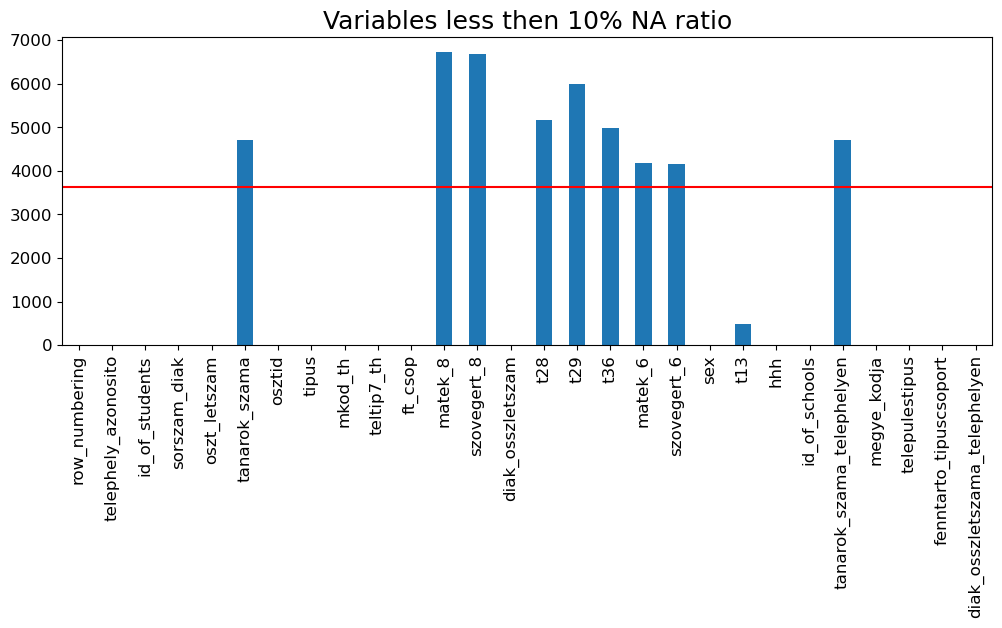

In [61]:
# data read once again so rerunning this chunk with different NA ratio wont influence the database
data = pd.read_csv('../data/okm_diak_adat.csv', low_memory = False)
data.rename(columns={
    'Unnamed: 0': 'row_numbering',
    'X.x': 'id_of_students',
    'X.y': 'id_of_schools'
}, inplace=True)

# dropingp columns from df where the proportion of missing values (NaN) is higher than 'ratio' (default: 0.60 = 60%).
def remove_highnan(df,ratio):
  for i in df.columns:
    if df[i].isnull().mean() > ratio:
      df.drop(i,axis = 1,inplace = True) # if its more than 0.6 ratio of Nas, drop the column

remove_highnan(data, na_ratio)

print(f"{percentage_of_NA:.0%} of the dataframe length (red line):", round(len(data)*percentage_of_NA,1), "(just for help deciding which variables to use)")
print()
data_2 = data.copy() # copy of the cleaned data (backup)
data.isnull().sum().plot(kind = 'bar', fontsize = 12,figsize = (12,4))
plt.title(f'Variables less then {na_ratio:.0%} NA ratio', fontsize=18)
plt.axhline(y=len(data)*percentage_of_NA, color='red')
plt.show()

In [62]:
print("Available features:")
print("-----")
for col in data.columns:
    print(col)
print("-----")    

Available features:
-----
row_numbering
telephely_azonosito
id_of_students
sorszam_diak
oszt_letszam
tanarok_szama
osztid
tipus
mkod_th
teltip7_th
ft_csop
matek_8
szovegert_8
diak_osszletszam
t28
t29
t36
matek_6
szovegert_6
sex
t13
hhh
id_of_schools
tanarok_szama_telephelyen
megye_kodja
telepulestipus
fenntarto_tipuscsoport
diak_osszletszama_telephelyen
-----


**!disclaimer!** \
estimated time of run can be long on older pc-s \
(for me the average run time is 30sec)

In [74]:
# Import the MissForest imputer for missing-value imputation
# !pip install missForest
from missforest.missforest import MissForest
# https://pypi.org/project/MissForest/

# set a seed, so rerunning the code wont change the imputation and the later results
seed_from_our_fav_numbers=314+133+76223+3+5
np.random.seed(seed_from_our_fav_numbers)


# columns we dont want to impute 
target_cols = ['matek_8', 'szovegert_8', 'matek_6', 'szovegert_6']  
X = data.drop(columns = target_cols)
y = data[target_cols]

# in the next code at "imputer_mixed" the python crashes, so we applied another solution:
# all categorical variables:
cat_cols = ['telephely_azonosito', 'mkod_th', 'teltip7_th', 'ft_csop', 't28', 't29',
            't36', 'sex', 'hhh', 't5a', 't5b', 't20', 't21a', 't21b', 't21c', 't21d',
            't22_b', 't23_b', 't24_b', 't25_b', 't26_b', 't30a', 't31a', 't34',
            't35a', 't35b', 't35c', 't35d', 't37', 't38a', 't38b', 't39', 't40a',
            't40b', 't40c', 't40d', 't40e', 't41', 't44a', 't44b', 't44c', 't48',
            't52', 't54a', 't54b', 't54c', 't55a', 't55b', 't55c', 't55d', 't55e',
            't56', 'megye_kodja', 'telepulestipus', 'fenntarto_tipuscsoport']

# ensure only existing columns are converted
for c in cat_cols:
    if c in X.columns: # converting column to pandas 'category' type, then replace categories with integer codes (0, 1, 2, ...) 
        X[c] = X[c].astype('category').cat.codes               #                                             so MissForest can handle them.

np.random.seed(seed_from_our_fav_numbers)
# 10 iterations of the imputation process, but it can stop earlier the imputation error (NRMSE) stops
#                                                                               improving (usually it stops around 4-5 iterations )

imputer_mixed = MissForest(max_iter = 10)     # this commented part is worked for a time, but after few days it stopped working so we introduced the solution mentioned above
X_imp = imputer_mixed.fit_transform(X) #, categorical = ['telephely_azonosito', 'mkod_th', 'teltip7_th', 'ft_csop', 't28', 't29', 't36', 'sex', 'hhh', 't5a', 't5b', 't20', 't21a', 't21b', 't21c', 't21d', 't22_b', 't23_b', 't24_b', 't25_b', 't26_b', 't30a', 't31a', 't34', 't35a', 't35b', 't35c', 't35d', 't37', 't38a', 't38b', 't39', 't40a', 't40b', 't40c', 't40d', 't40e', 't41', 't44a', 't44b', 't44c', 't48', 't52', 't54a', 't54b', 't54c', 't55a', 't55b', 't55c', 't55d', 't55e', 't56', 'megye_kodja', 'telepulestipus', 'fenntarto_tipuscsoport'])

X_imp = pd.DataFrame(X_imp, columns = X.columns) # convert the imputed NumPy array back to a df
X_imputed = pd.concat([X_imp, y], axis = 1) # re-attach the untouched target columns to the imputed variables (X_imp)

/opt/anaconda3/lib/python3.13/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.13/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/anaconda3/lib/python3.13/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 50%|██████████████████████                      | 5/10 [00:41<00:41,  8.31s/it]
/opt/anaconda3/lib/python3.13/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3

In [75]:
# saving the dataset
X_imputed.to_csv('../data/imputed_okm_diak_adat.csv', index=False)

# import data again and check NAs
data_imputed = pd.read_csv('../data/imputed_okm_diak_adat.csv', low_memory=False)
data_imputed.isnull().sum()#.plot(kind = 'bar', fontsize = 12,figsize = (12,4))
# now only the independent variables have NA-s -> good👍

row_numbering                       0
telephely_azonosito                 0
id_of_students                      0
sorszam_diak                        0
oszt_letszam                        0
tanarok_szama                       0
osztid                              0
tipus                               0
mkod_th                             0
teltip7_th                          0
ft_csop                             0
diak_osszletszam                    0
t28                                 0
t29                                 0
t36                                 0
sex                                 0
t13                                 0
hhh                                 0
id_of_schools                       0
tanarok_szama_telephelyen           0
megye_kodja                         0
telepulestipus                      0
fenntarto_tipuscsoport              0
diak_osszletszama_telephelyen       0
matek_8                          6734
szovegert_8                      6683
matek_6     